In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import gensim
import nltk
nltk.download('punkt')

import seaborn as sns
import matplotlib.pyplot as plt

import ast

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#!pip install tensorflow
import tensorflow as tf

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Bidirectional, LSTM
from tensorflow.keras.models import load_model

from matplotlib.ticker import MultipleLocator

from scipy.special import softmax

# I will be creating two ensemble models. One combining the best Bi-LSTM model for lyric content, using average of the embeddings, with the best song-level lyric sentiment model, Decision Tree Classifier. The other combines the best Bi-LSTM model for lyric content, using average of the embeddings, with the best line-level lyric sentiment model, Naives Bayes Classifier.

## A. Base steps applicable to both ensemble models

### 1. Import the data/word2vec/models and set up

#### a. Import the custom word2vec model that I created

In [ ]:
model_path = "/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/word_two_vec_model.model"
model_w2v = Word2Vec.load(model_path)

#### b. Processing lines into tokens for bi-lstm model

In [ ]:
ensemble_lstm = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/train_clean_w_sentiment.csv')

In [ ]:
lyric_lists = [song.splitlines() for song in ensemble_lstm['Lyrics']]
ensemble_lstm['Lyrics as Lists'] = lyric_lists
ensemble_lstm.head(2)

,Unnamed: 0.1,Unnamed: 0,Artist,Song,Genre,Language,Lyrics,Sentiment,Lyrics as Lists
0,0,78168,franz ferdinand,swallow smile,Rock,en,I rise and curse the waking day\nCurse the gri...,0,"[I rise and curse the waking day, Curse the gr..."
1,1,155890,ry cooder,big bad bill is sweet william now,Rock,en,In the town of Louisville they got a man they ...,-1,[In the town of Louisville they got a man they...


In [ ]:
train_lstm, val_lstm = train_test_split(ensemble_lstm, test_size=0.2, random_state=24, stratify = ensemble_lstm['Genre'])

In [ ]:
train_lyrics = train_lstm['Lyrics as Lists']
val_lyrics = val_lstm['Lyrics as Lists']

In [ ]:
def lyrics_to_embeddings(lines, model):
    tokenized_lines = [word_tokenize(line.lower()) for line in lines]
    embeddings = [model.wv[word] for line in tokenized_lines for word in line if word in model.wv.key_to_index]
    return embeddings

In [ ]:
train_lstm['Embeddings'] = train_lstm['Lyrics as Lists'].apply(lambda x: lyrics_to_embeddings(x, model_w2v))
val_lstm['Embeddings'] = val_lstm['Lyrics as Lists'].apply(lambda x: lyrics_to_embeddings(x, model_w2v))

#### c. Compile the bi-lstm model for lyric content

All of these steps are explained in detail in the baselineBiDirectionLSTM notebook

In [ ]:
train_lstm['WholeSongEmbedding'] = train_lstm['Embeddings'].apply(lambda x: np.mean(x, axis=0))
val_lstm['WholeSongEmbedding'] = val_lstm['Embeddings'].apply(lambda x: np.mean(x, axis=0))

In [ ]:
train_lstm['WholeSongEmbedding'] = train_lstm['WholeSongEmbedding'].apply(lambda x: np.array(x))
val_lstm['WholeSongEmbedding'] = val_lstm['WholeSongEmbedding'].apply(lambda x: np.array(x))

In [ ]:
train_lstm['Genre'] = train_lstm['Genre'].astype('category').cat.codes
val_lstm['Genre'] = val_lstm['Genre'].astype('category').cat.codes

# need to convert genre labels to one-hot encoding to use the keras library
y_train = tf.keras.utils.to_categorical(train_lstm['Genre'], num_classes=10)
y_val = tf.keras.utils.to_categorical(val_lstm['Genre'], num_classes=10)

In [ ]:
X_train = train_lstm['WholeSongEmbedding']
X_val = val_lstm['WholeSongEmbedding']

In [ ]:
X_train_array = np.vstack(X_train)

In [ ]:
X_val_array = np.vstack(X_val)

In [ ]:
scaler_lstm = StandardScaler()
X_train = scaler_lstm.fit_transform(X_train_array)
X_val = scaler_lstm.transform(X_val_array)

In [ ]:
print(len(X_train))
print(len(X_val))
print(len(y_train))
print(len(y_val))

12000
3000
12000
3000


In [ ]:
X_train_array = np.array([np.array(embeddings) for embeddings in X_train])

In [ ]:
print(X_train_array.shape)

(12000, 100)


In [ ]:
# sequence length is 100
sequence_length = X_train_array.shape[1]

# reshaping for use in lstm, needs number of features (one, the word embeddings vector)
X_train_array = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], 1)

Loading in the model I saved.

In [ ]:
model_lstm = load_model('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/best_bilstm_content')

## B. Song-Level Lyric sentiment Ensemble Model

### 1. Train the Decision Tree for sentiment

In [ ]:
X_train_dtc = train_lstm['Sentiment']
y_train_dtc = train_lstm['Genre']

X_val_dtc = val_lstm['Sentiment']
y_val_dtc = val_lstm['Genre']

In [ ]:
scaler_dtc = StandardScaler()
X_train_dtc = scaler_dtc.fit_transform(np.array(X_train_dtc).reshape(-1,1))
X_val_dtc = scaler_dtc.transform(np.array(X_val_dtc).reshape(-1,1))

In [ ]:
model_dtc_sent = DecisionTreeClassifier()
model_dtc_sent.fit(np.array(X_train_dtc).reshape(-1,1), np.array(y_train_dtc).reshape(-1,1))

DecisionTreeClassifier()

### 2. Create and run the blended model

In [ ]:
class BiLSTMVotingClassifierDTC:
    def __init__(self, models, lstm_weight=1, dtc_weight=1):
        self.models = models
        self.lstm_weight = lstm_weight
        self.dtc_weight = dtc_weight

    def fit(self, X_lstm, X_dtc, y_lstm, y_dtc):
        for model_type, model in self.models.items():
            if model_type == "bi_lstm":
                #model.fit(X_lstm, y_lstm)
                pass
            elif model_type == "dtc":
                model.fit(X_dtc, y_dtc)
            else:
                raise ValueError(f"Unknown model type: {model_type}")
        return self

    def predict(self, X_lstm, X_dtc):
        # Get raw predictions (not probabilities) using the predict method
        lstm_predictions = self.models["bi_lstm"].predict(X_lstm)
        dtc_predictions = self.models["dtc"].predict(X_dtc)

        # Check if the predictions are 1D arrays and reshape if necessary
        if len(lstm_predictions.shape) == 1:
            lstm_predictions = lstm_predictions.reshape(-1, 1)

        if len(dtc_predictions.shape) == 1:
            dtc_predictions = dtc_predictions.reshape(-1, 1)

        # Perform the weighted average of raw predictions
        weighted_avg_predictions = (
            self.lstm_weight * lstm_predictions + self.dtc_weight * dtc_predictions
        ) / (self.lstm_weight + self.dtc_weight)

        # Convert raw predictions to class probabilities using softmax
        probabilities = softmax(weighted_avg_predictions, axis=1)

        # Get the class with the maximum probability
        predicted_classes = np.argmax(probabilities, axis=1)

        return predicted_classes

In [ ]:
ensemble_classifier_lstm = BiLSTMVotingClassifierDTC(models={"bi_lstm": model_lstm, "dtc": model_dtc_sent})
ensemble_classifier_lstm.fit(X_train_array, X_train_dtc, y_train, y_train_dtc)

In [ ]:
# Standardize test features
#X_val_lstm_scale = scaler_lstm.transform(X_val_processed)
#X_val_dtc_scale = scaler_dtc.transform(X_val_dtc)

# Make predictions using the ensemble classifier
y_pred = ensemble_classifier_lstm.predict(X_val, X_val_dtc)

94/94 [==============================] - 1s 5ms/step


In [ ]:
y_pred

array([6, 4, 4, ..., 6, 3, 2])

In [ ]:
y_true = np.argmax(y_val, axis=1)
y_true

array([3, 0, 7, ..., 6, 3, 0])

### 3. Evaluate the model

In [ ]:
# Evaluate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(accuracy)

0.27566666666666667


In [ ]:
cm = confusion_matrix(y_true, y_pred)

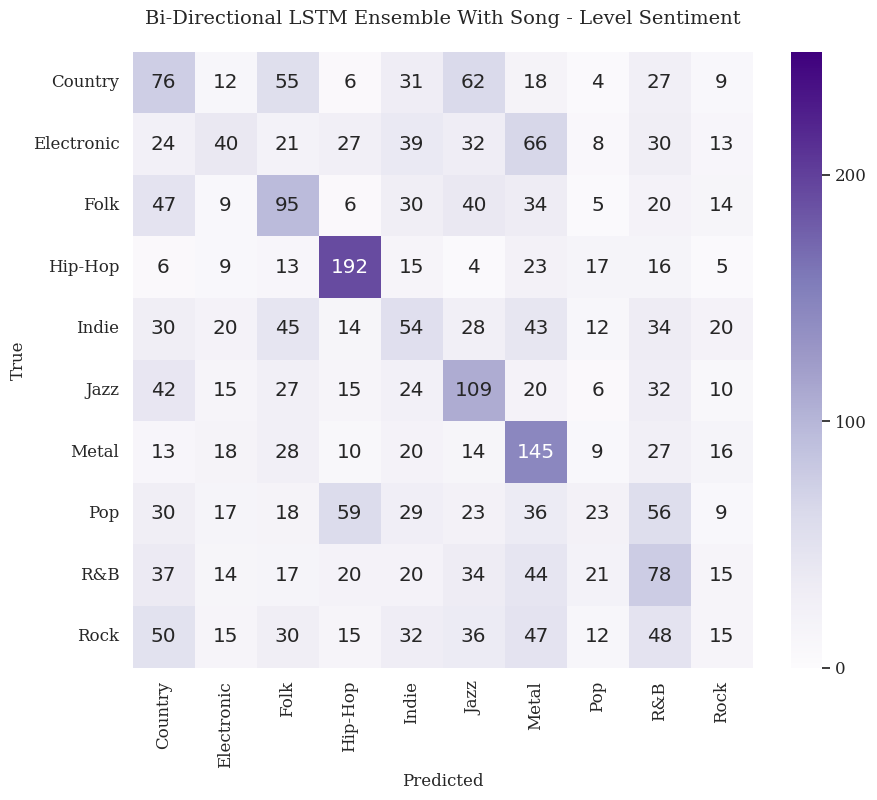

In [ ]:
genre_names = ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz',
       'Metal', 'Pop', 'R&B', 'Rock']


plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
heatmap = sns.heatmap(cm, annot=True,fmt='d',cmap='Purples',xticklabels=genre_names,yticklabels=genre_names,vmin=0,
    vmax=250,
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(),
    fontdict={'fontsize': 12, 'fontweight': 'normal', 'fontfamily': 'Serif'},
)
heatmap.set_yticklabels(
    heatmap.get_yticklabels(),
    fontdict={'fontsize': 12, 'fontweight': 'normal', 'fontfamily': 'Serif'},
)

cbar = heatmap.collections[0].colorbar
cbar.ax.yaxis.set_major_locator(MultipleLocator(100))

for label in cbar.ax.yaxis.get_ticklabels():
    label.set_fontname('Serif')
    label.set_fontsize(12)

plt.xlabel('Predicted', fontsize=12, fontfamily='Serif')
plt.ylabel('True', fontsize=12, fontfamily='Serif')
plt.title('Bi-Directional LSTM Ensemble With Song - Level Sentiment', fontsize=14, fontfamily='Serif', pad = 20)

plt.savefig('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/bilstm_ensemble_songlevel.png', bbox_inches='tight')

## C. Line-Level Lyric Semantic Ensemble Models

### 1. Import and pre-process the sentiment data
These steps are outlined more in the lyric sentiment notebook

In [ ]:
sent_data_subset_line = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/train_sentiment_lines_sciclone_complete.csv')

In [ ]:
train_lstm_sent_line, val_lstm_sent_line = train_test_split(sent_data_subset_line, test_size=0.2, random_state=24, stratify = sent_data_subset_line['Genre'])

In [ ]:
X_train_line = np.array(train_lstm_sent_line['SentimentLines'])
y_train_line = train_lstm_sent_line['Genre']

X_val_line = np.array(val_lstm_sent_line['SentimentLines'])
y_val_line = val_lstm_sent_line['Genre']

In [ ]:
X_train_line = np.array([ast.literal_eval(s) for s in X_train_line])
X_val_line = np.array([ast.literal_eval(s) for s in X_val_line])

In [ ]:
label_encoder = LabelEncoder()
y_train_line_encoded = label_encoder.fit_transform(y_train_line)
y_train_one_hot = to_categorical(y_train_line_encoded, num_classes=10)

In [ ]:
X_train_line = np.array(X_train_line)
y_train_one_hot = np.array(y_train_one_hot)

In [ ]:
max_sequence_length = 41
X_train_padded = pad_sequences(X_train_line, maxlen=max_sequence_length, padding='post', truncating='post')

In [ ]:
X_train_padded_shifted = X_train_padded + 5

Validation data:

In [ ]:
y_val_line_encoded = label_encoder.fit_transform(y_val_line)
y_val_one_hot = to_categorical(y_val_line_encoded, num_classes=10)

In [ ]:
X_val_line = np.array(X_val_line)
y_val_one_hot = np.array(y_val_one_hot)

In [ ]:
X_val_padded = pad_sequences(X_val_line, maxlen=41, padding='post', truncating='post')
X_val_padded_shifted = X_val_padded + 5

In [ ]:
y_train_labels = np.argmax(y_train_one_hot, axis=1)

### 2. Train the Naive Bayes Classifier for Sentiment

In [ ]:
scaler_nb = StandardScaler()
X_train_nb = scaler_nb.fit_transform(X_train_padded_shifted)
X_val_nb= scaler_nb.transform(X_val_padded_shifted)

In [ ]:
model_nb_sent = GaussianNB()
model_nb_sent.fit(X_train_nb, np.array(y_train_labels))

GaussianNB()

### 3. Create and run the blended model

In [ ]:
class BiLSTMVotingClassifierNB:
    def __init__(self, models, lstm_weight = 1, nb_weight = 1):
        self.models = models
        self.lstm_weight = lstm_weight
        self.nb_weight = nb_weight

    def fit(self, X_lstm, X_nb, y_lstm, y_nb):
        for model_type, model in self.models.items():
            if model_type == "bi_lstm":
                model.fit(X_lstm, y_lstm, batch_size=32, epochs=8, validation_split=0.2)
            elif model_type == "nb":
                model.fit(X_nb, y_nb)
            else:
                raise ValueError(f"Unknown model type: {model_type}")
        return self

    def predict(self, X_lstm, X_nb):
        # Get raw predictions (not probabilities) using the predict method
        lstm_predictions = self.models["bi_lstm"].predict(X_lstm)
        nb_predictions = self.models["nb"].predict(X_nb)

        # Check if the predictions are 1D arrays and reshape if necessary
        if len(lstm_predictions.shape) == 1:
            lstm_predictions = lstm_predictions.reshape(-1, 1)

        if len(nb_predictions.shape) == 1:
            nb_predictions = nb_predictions.reshape(-1, 1)

        # Perform the weighted average of raw predictions
        weighted_avg_predictions = (
            self.lstm_weight * lstm_predictions + self.nb_weight * nb_predictions
        ) / (self.lstm_weight + self.nb_weight)

        # Convert raw predictions to class probabilities using softmax
        probabilities = softmax(weighted_avg_predictions, axis=1)

        # Get the class with the maximum probability
        predicted_classes = np.argmax(probabilities, axis=1)

        return predicted_classes

In [ ]:
model_lstm = load_model('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/best_bilstm_content')

In [ ]:
ensemble_classifier_lstm_2 = BiLSTMVotingClassifierNB(models={"bi_lstm": model_lstm, "nb": model_nb_sent})
ensemble_classifier_lstm_2.fit(X_train_array, X_train_nb, y_train, y_train_labels)

Epoch 1/8
300/300 [==============================] - 7s 12ms/step - loss: 2.2608 - accuracy: 0.2070 - val_loss: 2.1598 - val_accuracy: 0.2454
Epoch 2/8
300/300 [==============================] - 3s 10ms/step - loss: 2.0777 - accuracy: 0.2520 - val_loss: 2.0887 - val_accuracy: 0.2508
Epoch 3/8
300/300 [==============================] - 4s 13ms/step - loss: 2.0278 - accuracy: 0.2694 - val_loss: 2.0636 - val_accuracy: 0.2558
Epoch 4/8
300/300 [==============================] - 4s 12ms/step - loss: 1.9924 - accuracy: 0.2831 - val_loss: 2.0542 - val_accuracy: 0.2683
Epoch 5/8
300/300 [==============================] - 3s 10ms/step - loss: 1.9653 - accuracy: 0.2922 - val_loss: 2.0481 - val_accuracy: 0.2767
Epoch 6/8
300/300 [==============================] - 3s 10ms/step - loss: 1.9444 - accuracy: 0.3077 - val_loss: 2.0437 - val_accuracy: 0.2783
Epoch 7/8
300/300 [==============================] - 3s 10ms/step - loss: 1.9226 - accuracy: 0.3148 - val_loss: 2.0423 - val_accuracy: 0.2788
Epoch 

In [ ]:
# Make predictions using the ensemble classifier
y_pred = ensemble_classifier_lstm_2.predict(X_val, X_val_nb)

94/94 [==============================] - 1s 7ms/step


In [ ]:
y_true = np.argmax(y_val, axis=1)
y_true

array([3, 0, 7, ..., 6, 3, 0])

### 4. Evaluate the model

In [ ]:
# Evaluate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(accuracy)

0.2783333333333333


In [ ]:
cm = confusion_matrix(y_true, y_pred)

In [ ]:
cm

array([[ 75,   6,  52,   8,  37,  58,   8,  11,  27,  18],
       [ 25,  43,  22,  26,  42,  28,  45,  21,  36,  12],
       [ 52,  11,  89,   3,  40,  37,  25,   9,  18,  16],
       [  7,  11,  18, 191,  16,   4,  12,  24,  12,   5],
       [ 30,  21,  34,  14,  57,  33,  31,  23,  39,  18],
       [ 41,  11,  33,  14,  33,  98,  12,  10,  35,  13],
       [ 12,  24,  23,  11,  30,  19, 118,  18,  30,  15],
       [ 20,  15,  15,  55,  35,  31,  19,  29,  64,  17],
       [ 34,  17,  14,  19,  25,  34,  23,  26,  97,  11],
       [ 41,  21,  32,  14,  30,  40,  31,  22,  46,  23]])

### 5. Train the RNN for Line Sentiment

In [ ]:
scaler_rnn = StandardScaler()
X_train_rnn = scaler_rnn.fit_transform(X_train_padded_shifted)
X_val_rnn = scaler_rnn.transform(X_val_padded_shifted)

In [ ]:
model_rnn = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/model_sentiment_line_rnn")

In [ ]:
model_lstm = load_model('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/best_bilstm_content')

### 6. Create and Run the Blended Model

In [ ]:
class BiLSTMVotingClassifierRNN:
    def __init__(self, models, lstm_weight=1, rnn_weight=1):
        self.models = models
        self.lstm_weight = lstm_weight
        self.rnn_weight = rnn_weight

    def fit(self, X_lstm, X_rnn, y):
        for model_type, model in self.models.items():
            if model_type == "bi_lstm":
                model.fit(X_lstm, y, batch_size=32, epochs=8, validation_split=0.2)
            elif model_type == "rnn":
                model.fit(X_rnn, y, epochs=5, batch_size=32, validation_split=0.2)
            else:
                raise ValueError(f"Unknown model type: {model_type}")
        return self

    def predict(self, X_lstm, X_rnn):
        lstm_predictions = self.models["bi_lstm"].predict(X_lstm)
        rnn_predictions = self.models["rnn"].predict(X_rnn)

        # Check if the predictions are 1D arrays and reshape if necessary
        if len(lstm_predictions.shape) == 1:
            lstm_predictions = lstm_predictions.reshape(-1, 1)

        if len(rnn_predictions.shape) == 1:
            rnn_predictions = rnn_predictions.reshape(-1, 1)

        # Weighted average of class probabilities from both models
        weighted_avg_probabilities = (
            self.lstm_weight * lstm_predictions + self.rnn_weight * rnn_predictions
        ) / (self.lstm_weight + self.rnn_weight)

        # Convert raw predictions to class probabilities using softmax
        probabilities = softmax(weighted_avg_probabilities, axis=1)

        # Get the class with the maximum probability
        predicted_classes = np.argmax(probabilities, axis=1)

        return predicted_classes

In [ ]:
ensemble_classifier_lstm_rnn = BiLSTMVotingClassifierRNN(models={"bi_lstm": model_lstm, "rnn": model_rnn})
ensemble_classifier_lstm_rnn.fit(X_train_array, X_train_rnn, y_train_one_hot)

Epoch 1/8
300/300 [==============================] - 4s 12ms/step - loss: 1.8983 - accuracy: 0.3203 - val_loss: 2.0563 - val_accuracy: 0.2821
Epoch 2/8
300/300 [==============================] - 3s 11ms/step - loss: 1.8748 - accuracy: 0.3308 - val_loss: 2.0677 - val_accuracy: 0.2729
Epoch 3/8
300/300 [==============================] - 4s 15ms/step - loss: 1.8591 - accuracy: 0.3370 - val_loss: 2.0608 - val_accuracy: 0.2783
Epoch 4/8
300/300 [==============================] - 4s 13ms/step - loss: 1.8396 - accuracy: 0.3434 - val_loss: 2.0648 - val_accuracy: 0.2800
Epoch 5/8
300/300 [==============================] - 4s 14ms/step - loss: 1.8208 - accuracy: 0.3518 - val_loss: 2.0751 - val_accuracy: 0.2783
Epoch 6/8
300/300 [==============================] - 3s 11ms/step - loss: 1.7995 - accuracy: 0.3642 - val_loss: 2.0737 - val_accuracy: 0.2796
Epoch 7/8
300/300 [==============================] - 4s 14ms/step - loss: 1.7874 - accuracy: 0.3672 - val_loss: 2.0793 - val_accuracy: 0.2837
Epoch 

In [ ]:
y_pred = ensemble_classifier_lstm_rnn.predict(X_val, X_val_rnn)

94/94 [==============================] - 1s 12ms/step


In [ ]:
y_pred

array([3, 1, 1, ..., 6, 3, 2])

In [ ]:
y_val_labels = np.argmax(y_val_one_hot, axis=1)
y_val_labels

array([3, 0, 7, ..., 6, 3, 0])

### 7. Evaluate the model

In [ ]:
accuracy = accuracy_score(y_val_labels, y_pred)
accuracy

0.3323333333333333

In [ ]:
cm = confusion_matrix(y_val_labels, y_pred)

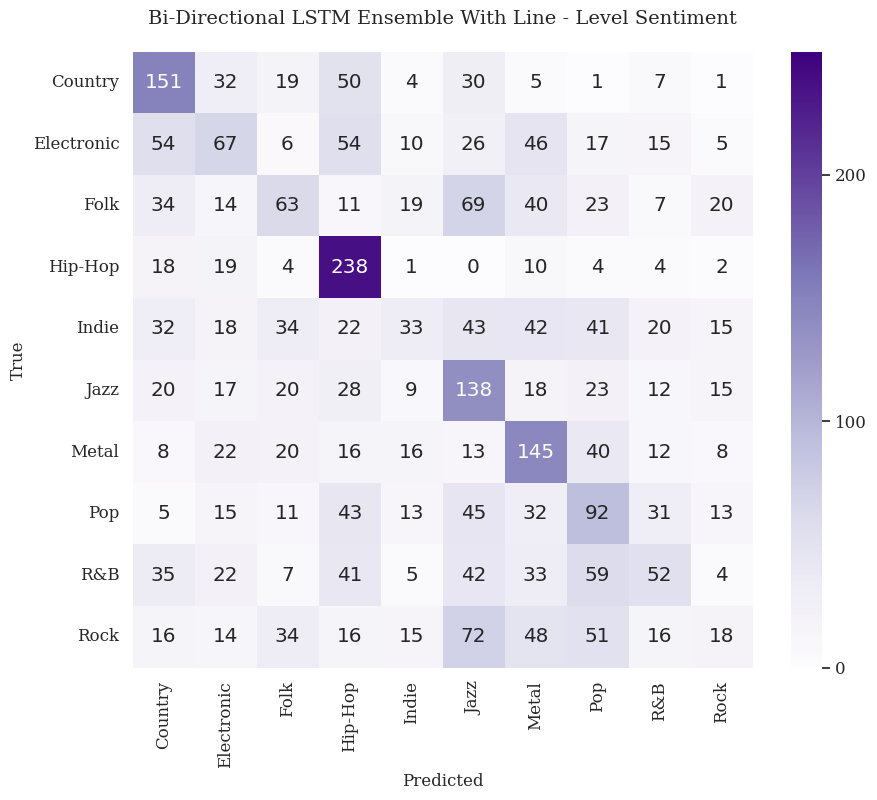

In [ ]:
genre_names = ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz',
       'Metal', 'Pop', 'R&B', 'Rock']


plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
heatmap = sns.heatmap(cm, annot=True,fmt='d',cmap='Purples',xticklabels=genre_names,yticklabels=genre_names,vmin=0,
    vmax=250,
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(),
    fontdict={'fontsize': 12, 'fontweight': 'normal', 'fontfamily': 'Serif'},
)
heatmap.set_yticklabels(
    heatmap.get_yticklabels(),
    fontdict={'fontsize': 12, 'fontweight': 'normal', 'fontfamily': 'Serif'},
)

cbar = heatmap.collections[0].colorbar
cbar.ax.yaxis.set_major_locator(MultipleLocator(100))

for label in cbar.ax.yaxis.get_ticklabels():
    label.set_fontname('Serif')
    label.set_fontsize(12)

plt.xlabel('Predicted', fontsize=12, fontfamily='Serif')
plt.ylabel('True', fontsize=12, fontfamily='Serif')
plt.title('Bi-Directional LSTM Ensemble With Line - Level Sentiment', fontsize=14, fontfamily='Serif', pad = 20)

plt.savefig('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/bilstm_ensemble_linelevel.png', bbox_inches='tight')